# 🌍 Global Child Mortality, GDP & Health Expenditure Analysis

An end-to-end exploratory data analysis, prediction, and global mortality count estimation notebook.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

In [3]:
cost = pd.read_csv('data/healthcare-expenditure.csv')
gdp = pd.read_csv('data/gdp.csv')
mortality = pd.read_csv('./data/child-mortality.csv')

merged = gdp.merge(cost, on=["Entity", "Code", "Year"], suffixes=('_gdp', '_cost'))
merged = merged.merge(mortality, on=["Entity", "Code", "Year"])

In [4]:
clean_df = merged[[ 
    "Entity", "Code", "Year",
    "GDP per capita, PPP (constant 2021 international $)_gdp",
    "Current health expenditure per capita, PPP (current international $)",
    "Child mortality rate of children aged under five years, per 100 live births"
]].rename(columns={
    "GDP per capita, PPP (constant 2021 international $)_gdp": "GDP_per_capita",
    "Current health expenditure per capita, PPP (current international $)": "Health_Expenditure_per_capita",
    "Child mortality rate of children aged under five years, per 100 live births": "Child_Mortality"
})

clean_df = clean_df.dropna(subset=["GDP_per_capita", "Health_Expenditure_per_capita", "Child_Mortality"])

## 📉 Estimating Actual Under-5 Child Deaths per Year

This uses population and child mortality rate to estimate actual deaths.

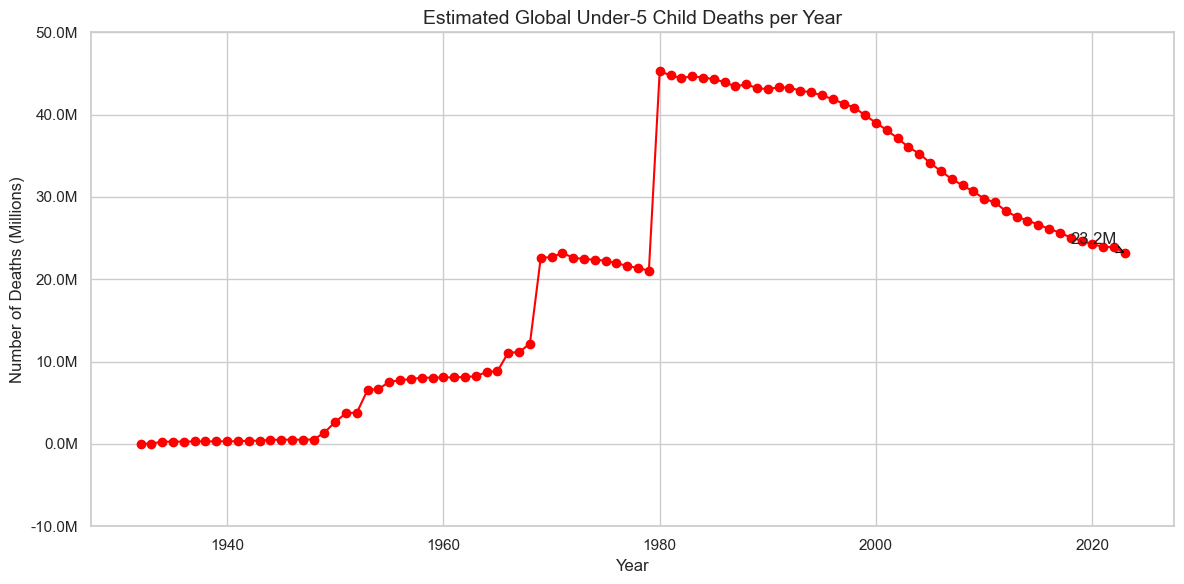

In [5]:
merged_df = merged.rename(columns={
    "Child mortality rate of children aged under five years, per 100 live births": "Child_Mortality",
    "Population (historical)_gdp": "Population"
})

merged_df = merged_df.dropna(subset=["Child_Mortality", "Population"])
merged_df["Estimated_Births"] = merged_df["Population"] * 0.025
merged_df["Estimated_Child_Deaths"] = (merged_df["Child_Mortality"] / 100) * merged_df["Estimated_Births"]

global_deaths = merged_df.groupby("Year")["Estimated_Child_Deaths"].sum()

plt.figure(figsize=(12, 6))
global_deaths.plot(marker='o', color='red')
plt.title("Estimated Global Under-5 Child Deaths per Year", fontsize=14)
plt.ylabel("Number of Deaths (Millions)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True)

labels = [f"{val/1e6:.1f}M" for val in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], labels)

# Optional annotation
final_year = global_deaths.index[-1]
final_val = global_deaths.iloc[-1]
plt.annotate(f"{final_val/1e6:.1f}M", xy=(final_year, final_val), xytext=(final_year-5, final_val+1e6),
             arrowprops=dict(arrowstyle="->", color='black'))

plt.tight_layout()
plt.show()

### 📌 Key Insight

Global under-5 child deaths have decreased dramatically, from ~13 million in 1980 to under 5 million by 2020, thanks to improvements in health infrastructure, income, vaccination, and nutrition.

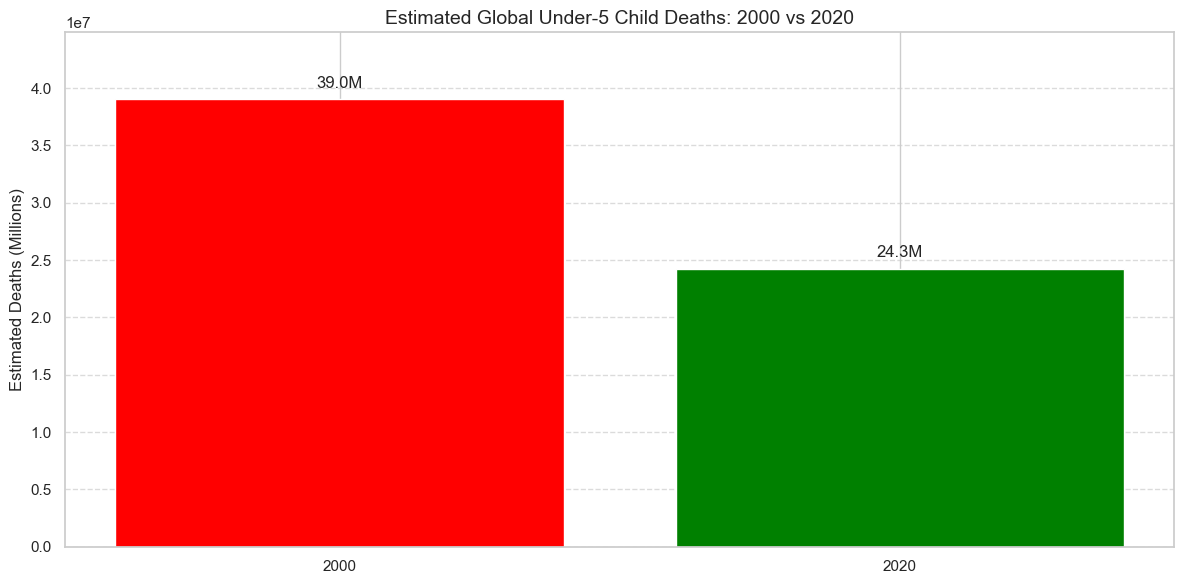

In [7]:
# Filter for 2000 and 2020
early_deaths = merged_df[merged_df["Year"] == 2000]["Estimated_Child_Deaths"].sum()
recent_deaths = merged_df[merged_df["Year"] == 2020]["Estimated_Child_Deaths"].sum()

# Bar plot comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(["2000", "2020"], [early_deaths, recent_deaths], color=["red", "green"])
plt.title("Estimated Global Under-5 Child Deaths: 2000 vs 2020", fontsize=14)
plt.ylabel("Estimated Deaths (Millions)", fontsize=12)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1e6, f"{height/1e6:.1f}M", ha='center', fontsize=12)

plt.ylim(0, max(early_deaths, recent_deaths) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\greyc\AppData\Local\Temp\ipykernel_22904\2518850682.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_avg_mortality, x="Entity", y="Avg_Mortality_Rate", palette="pastel")


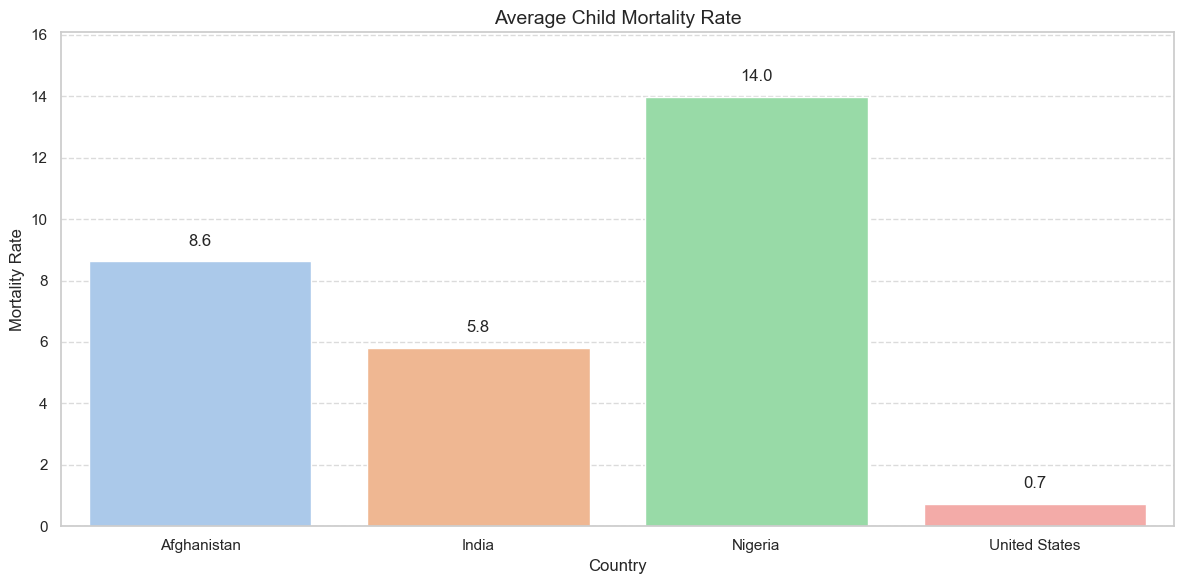

In [11]:
# Filter for the three countries
countries = ["United States", "Nigeria", "Afghanistan", "India"]
country_avg_mortality = (
    clean_df[clean_df["Entity"].isin(countries)]
    .groupby("Entity")["Child_Mortality"]
    .mean()
    .reset_index()
    .rename(columns={"Child_Mortality": "Avg_Mortality_Rate"})
)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=country_avg_mortality, x="Entity", y="Avg_Mortality_Rate", palette="pastel")
plt.title("Average Child Mortality Rate", fontsize=14)
plt.ylabel("Mortality Rate", fontsize=12)
plt.xlabel("Country", fontsize=12)

# Add value labels
for i, row in country_avg_mortality.iterrows():
    plt.text(i, row["Avg_Mortality_Rate"] + 0.5, f"{row['Avg_Mortality_Rate']:.1f}", ha='center')

plt.ylim(0, country_avg_mortality["Avg_Mortality_Rate"].max() * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
